In [1]:
from __future__ import division, print_function
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
sns.set_style("white")
np.random.seed(10)
matplotlib.rc("font", size=30)

# Example of using two distance + thresholds in one ABC sampling run

In [3]:
samples_size = 1000
mean = 2
sigma = 1
data = np.random.normal(mean, sigma, samples_size)

<IPython.core.display.Javascript object>


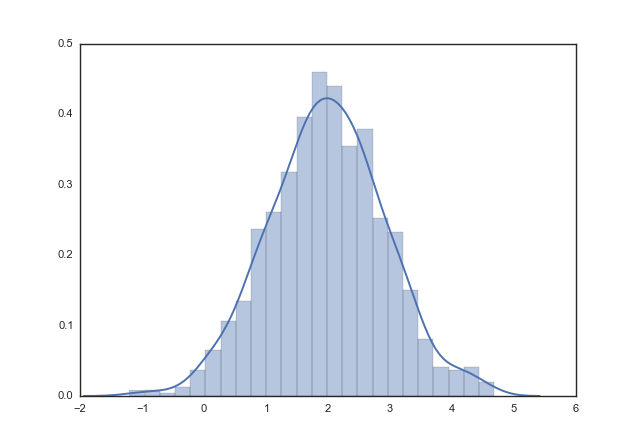

In [4]:
f,ax = plt.subplots()
sns.distplot(data)

In [5]:
def create_new_sample(theta):
    mu,sigma = theta
    if sigma<=0:
        sigma=10
    return np.random.normal(mu, sigma, samples_size)


### Distance measure compares mean + variance

In [6]:
def dist_measure(x, y):
    return [np.abs(np.mean(x, axis=0) - np.mean(y, axis=0)),
            np.abs(np.var(x, axis=0) - np.var(y, axis=0))]


In [7]:
distances = [dist_measure(data, create_new_sample((mean, sigma))) for _ in range(1000)]

In [8]:
dist_labels = ["mean", "var"]

<IPython.core.display.Javascript object>


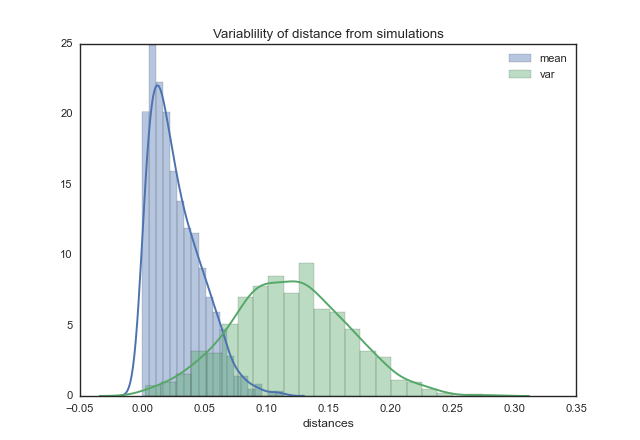

In [9]:
f, ax = plt.subplots()
sns.distplot(np.asarray(distances)[:, 0], axlabel="distances", label=dist_labels[0])
sns.distplot(np.asarray(distances)[:, 1], axlabel="distances", label=dist_labels[1])
plt.title("Variablility of distance from simulations")
plt.legend()

In [10]:
import abcpmc

In [11]:
prior = abcpmc.GaussianPrior(mu=[2.5, 1.5], sigma=np.eye(2) * 0.5)

In [12]:
alpha = 85
T = 100
eps_start = [1.0, 1.0]


In [13]:
sampler = abcpmc.Sampler(N=1000, Y=data, postfn=create_new_sample, dist=dist_measure, threads=7)

In [14]:
def launch():
    eps = abcpmc.ConstEps(T, eps_start)

    pools = []
    for pool in sampler.sample(prior, eps):
        eps_str = ", ".join(["{0:>.4f}".format(e) for e in pool.eps])
        print("T: {0}, eps: [{1}], ratio: {2:>.4f}".format(pool.t, eps_str, pool.ratio))

        for i, (mean, std) in enumerate(zip(*abcpmc.weighted_avg_and_std(pool.thetas, pool.ws, axis=0))):
            print(u"    theta[{0}]: {1:>.4f} \u00B1 {2:>.4f}".format(i, mean,std))

        eps.eps = np.percentile(pool.dists, alpha, axis=0) # reduce eps value
        pools.append(pool)
        if pool.ratio <0.2:
            break
    sampler.close()
    return pools


In [15]:
import time
t0 = time.time()
pools = launch()
print("took", (time.time() - t0))

T: 0, eps: [1.0000, 1.0000], ratio: 0.3308
    theta[0]: 2.2147 ± 0.4986
    theta[1]: 0.9309 ± 0.3391
T: 1, eps: [0.8217, 0.8518], ratio: 0.3854
    theta[0]: 2.1697 ± 0.4232
    theta[1]: 0.8797 ± 0.3179
T: 2, eps: [0.6793, 0.7696], ratio: 0.3772
    theta[0]: 2.1240 ± 0.3539
    theta[1]: 0.9052 ± 0.2549
T: 3, eps: [0.5509, 0.6490], ratio: 0.3764
    theta[0]: 2.0405 ± 0.3036
    theta[1]: 0.9117 ± 0.2185
T: 4, eps: [0.4668, 0.5436], ratio: 0.3658
    theta[0]: 2.0616 ± 0.2537
    theta[1]: 0.9260 ± 0.1676
T: 5, eps: [0.3785, 0.4291], ratio: 0.3524
    theta[0]: 2.0552 ± 0.1967
    theta[1]: 0.9210 ± 0.1374
T: 6, eps: [0.3006, 0.3494], ratio: 0.3183
    theta[0]: 1.9985 ± 0.1621
    theta[1]: 0.9221 ± 0.1043
T: 7, eps: [0.2328, 0.2764], ratio: 0.3173
    theta[0]: 2.0111 ± 0.1393
    theta[1]: 0.9282 ± 0.0894
T: 8, eps: [0.1934, 0.2310], ratio: 0.2964
    theta[0]: 1.9896 ± 0.1182
    theta[1]: 0.9418 ± 0.0729
T: 9, eps: [0.1657, 0.1743], ratio: 0.2886
    theta[0]: 1.9974 ± 0.0997


<IPython.core.display.Javascript object>


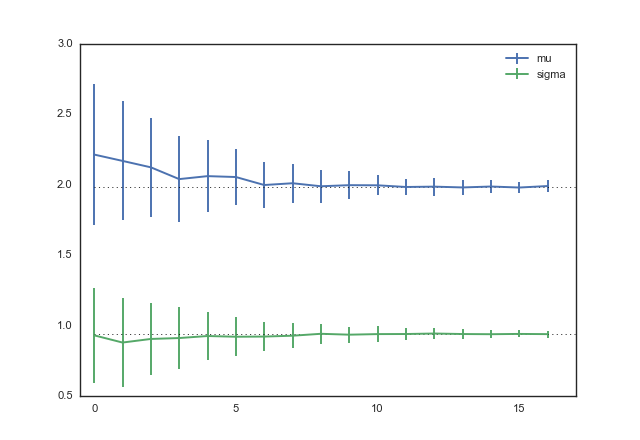

In [16]:
T = len(pools)
fig, ax = plt.subplots()
lables =["mu", "sigma"]
for i in range(2):
    moments = np.array([abcpmc.weighted_avg_and_std(pool.thetas[:,i], pool.ws, axis=0) for pool in pools])
    ax.errorbar(range(T), moments[:, 0], moments[:, 1], label=lables[i])
ax.hlines(np.mean(data), 0, T, linestyle="dotted", linewidth=0.7)
ax.hlines(np.std(data), 0, T, linestyle="dotted", linewidth=0.7)
ax.legend()
_ = ax.set_xlim([-.5, T])

<IPython.core.display.Javascript object>


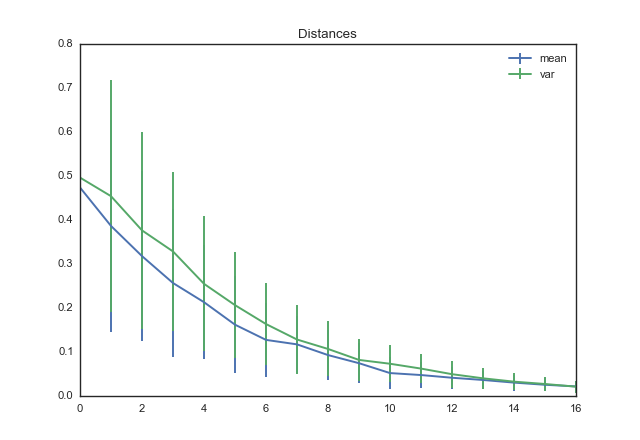

In [17]:
distances = np.array([pool.dists for pool in pools])
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(distances)), np.mean(distances, axis=1)[:, 0], np.std(distances, axis=1)[:, 0], label=dist_labels[0])
ax.errorbar(np.arange(len(distances)), np.mean(distances, axis=1)[:, 1], np.std(distances, axis=1)[:, 1], label=dist_labels[1])
ax.legend()
ax.set_title("Distances")

<IPython.core.display.Javascript object>


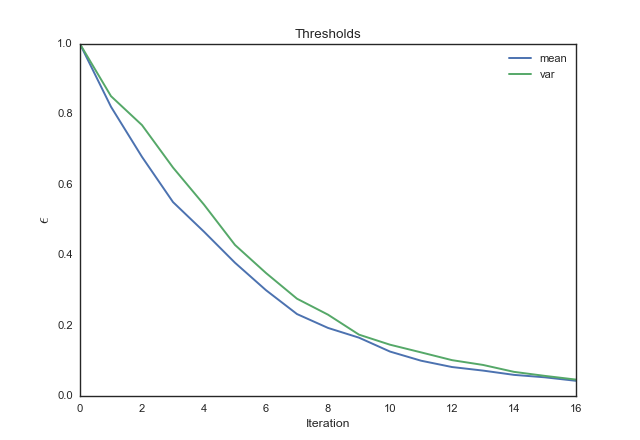

In [18]:
fig,ax = plt.subplots()
eps_values = np.array([pool.eps for pool in pools])
ax.plot(eps_values[:, 0], label=dist_labels[0])
ax.plot(eps_values[:, 1], label=dist_labels[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\epsilon$", fontsize=15)
ax.legend(loc="best")
ax.set_title("Thresholds")

<IPython.core.display.Javascript object>


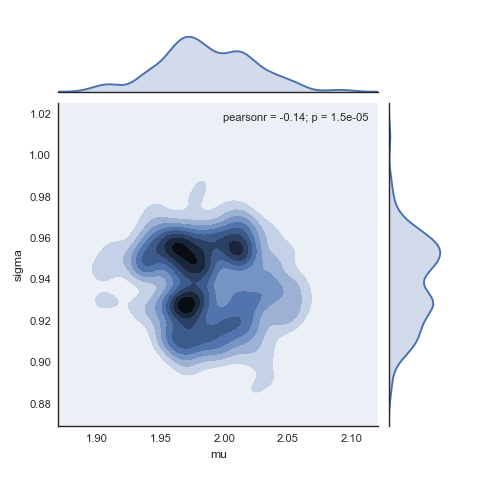

In [19]:
jg = sns.jointplot(pools[-1].thetas[:, 0], 
              pools[-1].thetas[:, 1], 
              kind="kde", 
             )
jg.ax_joint.set_xlabel(lables[0])
jg.ax_joint.set_ylabel(lables[1])